# MQTT

- MQTT (Message Queue Telemetry Transport)
- 為M2M, IOT設計的協定，基於TCP socket，主要是想讓系統資源較低的設備也可以把資料上傳到Server。
- 目前已是ISO的一員:
    - 2016, MQTT is now an ISO standard (ISO/IEC 20922)
- 本次教學中的MQTT雲端服務為Eclipse所提供：iot.eclipse.org    
- 架構如下：
    - 有興趣可以參考此[文章](https://www.javacodegeeks.com/2016/10/mqtt-protocol-tutorial.html)進一步了解
![mqtt](https://www.javacodegeeks.com/wp-content/uploads/2016/10/mqtt_publisher_subscriber-1.png)


# 利用手機和你的IOT設備互動


----
## 圖文併茂的Android手機監控APP - Linear MQTT Dashboard

* 先在android play上安裝Linear MQTT Dashboard
* 打開APP後的操作流程如下圖：
    * Led燈：malo-iot/light
    * 溫度：malo-iot/T
    * 溼度：malo-iot/H
    
![img](image/linear-mqtt1.png)


### 有資訊push上來後的畫面

![linear-mqtt1](image/linear-mqtt2.png)

In [ ]:
# 先安裝MQTT的module (for colab)
!pip install paho-mqtt

## 接收資料的方法: subscribe

In [1]:
import paho.mqtt.client as mqtt
import time, json, datetime, sys, os

#==================
#== MQTT Functions

# 當地端程式連線伺服器得到回應時，要做的動作
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    # 將訂閱主題寫在on_connet中
    # 如果我們失去連線或重新連線時 
    # 地端程式將會重新訂閱
    client.subscribe('/your-home/temp')
    

# 當接收到從伺服器發送的訊息時要進行的動作
def on_message(client, userdata, msg):
    # 轉換編碼utf-8才看得懂中文
    try:
        topic = msg.topic
        value = msg.payload.decode('utf-8')
        dtime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        print('(topic, value)=(%s, %s) @%s' %(topic, value, dtime))
    except Exception as e:
        print('read data exception: ', str(e))

def run_mqtt():
    try:
        # 連線設定
        # 初始化地端程式
        client = mqtt.Client()

        # 設定連線的動作
        client.on_connect = on_connect

        # 設定接收訊息的動作
        client.on_message = on_message

        # 設定登入帳號密碼
        #client.username_pw_set("try","xxxx")

        # 設定連線資訊(IP, Port, 連線時間)
        client.connect("broker.hivemq.com", 1883, 60)

        # 開始連線，執行設定的動作和處理重新連線問題
        # 也可以手動使用其他loop函式來進行連接
        #client.loop_forever()
        client.loop_start()    #start the loop

        time.sleep(30)

        client.disconnect() # disconnect gracefully
        client.loop_stop() # stops network loop
        
    except Exception as e:
        print('run mqtt error: ', str(e))

run_mqtt()


Connected with result code 0
(topic, value)=(/your-home/temp, 23) @2022-12-09 13:50:53
(topic, value)=(/your-home/temp, 25) @2022-12-09 13:50:58
(topic, value)=(/your-home/temp, 23) @2022-12-09 13:51:03
(topic, value)=(/your-home/temp, 29) @2022-12-09 13:51:08
(topic, value)=(/your-home/temp, 30) @2022-12-09 13:51:13
(topic, value)=(/your-home/temp, 27) @2022-12-09 13:51:18


### 把MQTT資訊送上Server(broker)

In [ ]:
# push mqtt msg

import paho.mqtt.client as mqtt
import time, json, datetime, sys, os
import random

def on_connect(client, userdata, flags, rc):
    m="Connected flags"+str(flags)+", result code "+str(rc)+", client_id  "+str(client)
    print(m)

# some online free broker:
#   iot.eclipse.org
#   test.mosquitto.org
#   broker.hivemq.com
broker_address = "broker.hivemq.com"
broker_port = 1883

client1 = mqtt.Client()    #create new instance
client1.on_connect = on_connect        #attach function to callback

time.sleep(0.5)
client1.connect(host=broker_address, port=broker_port, keepalive=60)      #connect to broker
topic_str = '/your-home/temp'
        
client1.loop_start()    #start the loop
time.sleep(0.5)
print("loop start")

#-- start to push data
for k in range(10):
    temp = 25 + random.randint(-3, 3)
    print('--> push', topic_str, temp)
    client1.publish(topic_str, temp, qos=1)
    time.sleep(5)

time.sleep(0.1)

client1.disconnect()


## 收集資料：進一步把資料記錄到變數中

In [2]:
import paho.mqtt.client as mqtt
import time, json, datetime, sys, os

temp_list = []
#==================
#== MQTT Functions

# 當地端程式連線伺服器得到回應時，要做的動作
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    # 將訂閱主題寫在on_connet中
    # 如果我們失去連線或重新連線時 
    # 地端程式將會重新訂閱
    client.subscribe('/your-home/temp')
    

# 當接收到從伺服器發送的訊息時要進行的動作
def on_message(client, userdata, msg):
    # 轉換編碼utf-8才看得懂中文
    try:
        topic = msg.topic
        value = msg.payload.decode('utf-8')
        dtime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        print('(topic, value)=(%s, %s) @%s' %(topic, value, dtime))
        temp_list.append(value)

    except Exception as e:
        print('read data exception: ', str(e))

def run_mqtt():
    try:
        # 連線設定
        # 初始化地端程式
        client = mqtt.Client()

        # 設定連線的動作
        client.on_connect = on_connect

        # 設定接收訊息的動作
        client.on_message = on_message

        # 設定登入帳號密碼
        #client.username_pw_set("try","xxxx")

        # 設定連線資訊(IP, Port, 連線時間)
        client.connect("broker.hivemq.com", 1883, 60)

        # 開始連線，執行設定的動作和處理重新連線問題
        # 也可以手動使用其他loop函式來進行連接
        #client.loop_forever()
        client.loop_start()    #start the loop

        time.sleep(30)

        client.disconnect() # disconnect gracefully
        client.loop_stop() # stops network loop
        
    except Exception as e:
        print('run mqtt error: ', str(e))

run_mqtt()

print(temp_list)


Connected with result code 0
(topic, value)=(/your-home/temp, 22) @2022-12-09 13:52:13
(topic, value)=(/your-home/temp, 22) @2022-12-09 13:52:18
(topic, value)=(/your-home/temp, 29) @2022-12-09 13:52:23
(topic, value)=(/your-home/temp, 22) @2022-12-09 13:52:28
(topic, value)=(/your-home/temp, 28) @2022-12-09 13:52:33
(topic, value)=(/your-home/temp, 26) @2022-12-09 13:52:38
['22', '22', '29', '22', '28', '26']


### 來畫個趨勢圖!

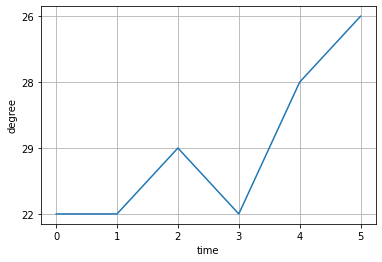

In [3]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(temp_list)
plt.xlabel('time')
plt.ylabel('degree')
plt.grid()

## 加入時間的記錄

In [4]:
import paho.mqtt.client as mqtt
import time, json, datetime, sys, os

temp_list = []
time_list = []
#==================
#== MQTT Functions

# 當地端程式連線伺服器得到回應時，要做的動作
def on_connect(client, userdata, flags, rc):
    print("Connected with result code "+str(rc))
    # 將訂閱主題寫在on_connet中
    # 如果我們失去連線或重新連線時 
    # 地端程式將會重新訂閱
    client.subscribe('/your-home/temp')
    

# 當接收到從伺服器發送的訊息時要進行的動作
def on_message(client, userdata, msg):
    # 轉換編碼utf-8才看得懂中文
    try:
        topic = msg.topic
        value = msg.payload.decode('utf-8')
        dtime = time.strftime("%Y-%m-%d %H:%M:%S", time.localtime())
        print('(topic, value)=(%s, %s) @%s' %(topic, value, dtime))
        temp_list.append(value)
        time_list.append(dtime)

    except Exception as e:
        print('read data exception: ', str(e))

def run_mqtt():
    try:
        # 連線設定
        # 初始化地端程式
        client = mqtt.Client()

        # 設定連線的動作
        client.on_connect = on_connect

        # 設定接收訊息的動作
        client.on_message = on_message

        # 設定登入帳號密碼
        #client.username_pw_set("try","xxxx")

        # 設定連線資訊(IP, Port, 連線時間)
        client.connect("broker.hivemq.com", 1883, 60)

        # 開始連線，執行設定的動作和處理重新連線問題
        # 也可以手動使用其他loop函式來進行連接
        #client.loop_forever()
        client.loop_start()    #start the loop

        time.sleep(30)

        client.disconnect() # disconnect gracefully
        client.loop_stop() # stops network loop
        
    except Exception as e:
        print('run mqtt error: ', str(e))

run_mqtt()

print(temp_list)
print(time_list)


Connected with result code 0
(topic, value)=(/your-home/temp, 24) @2022-12-09 13:53:08
(topic, value)=(/your-home/temp, 30) @2022-12-09 13:53:13
(topic, value)=(/your-home/temp, 22) @2022-12-09 13:53:18
(topic, value)=(/your-home/temp, 28) @2022-12-09 13:53:23
(topic, value)=(/your-home/temp, 30) @2022-12-09 13:53:28
(topic, value)=(/your-home/temp, 24) @2022-12-09 13:53:33
['24', '30', '22', '28', '30', '24']
['2022-12-09 13:53:08', '2022-12-09 13:53:13', '2022-12-09 13:53:18', '2022-12-09 13:53:23', '2022-12-09 13:53:28', '2022-12-09 13:53:33']


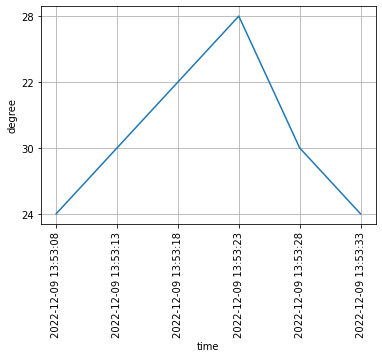

In [5]:
%matplotlib inline

import matplotlib.pyplot as plt

plt.plot(time_list, temp_list)
plt.xlabel('time')
plt.ylabel('degree')
plt.xticks(time_list, rotation=90)
plt.grid()

## TODO: 超出上限30度時，發出line警報

## TODO: 收集Malo農場的資訊

In [ ]:
topic_temp = '/malo/farm/temp'
topic_humi = '/malo/farm/humi'
topic_co2 = '/malo/farm/CO2'
topic_v = '/malo/farm/v3'
